# Gridded climate data for Vienna
This notebook will
- access gridded climate data over Vienna from GeoSphere Austria (via REST API)
- interpolate (regrid) climate data using ordinary Kriging

Problem: gridded climate data comes in CRS EPSG:3416, and we need to harmonise it with other datasets that are in CRS EPSG:31256. In the image below, we see the maximum daily temperature of 22.04.24 over Wien. The black grid represents the target datacube in EPSG:31256, also the outline of the districts are visible.
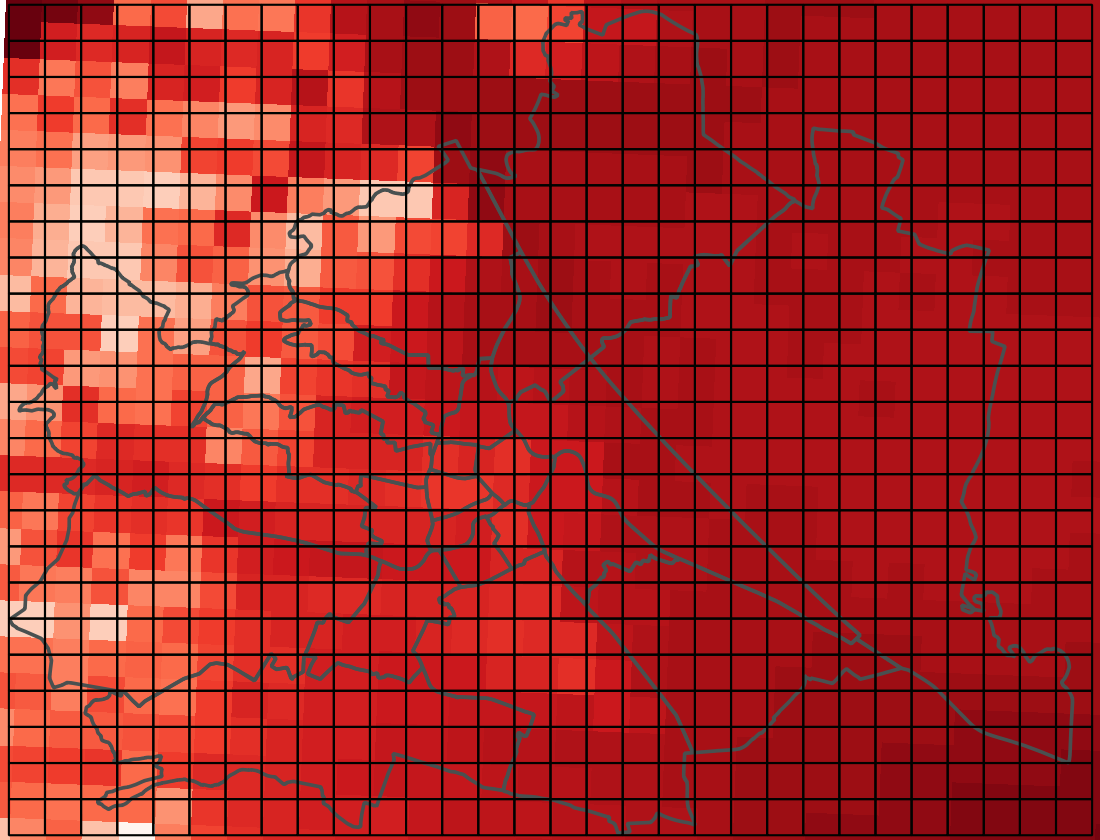

When zooming in, one can see that the climate data does not perfectly align with the target grid. To decide which temperature should be assigned, e.g., to the red cell (one cell=one value), one has to _interpolate_ the temperature using the values of the surrounding cells. Since temperature does not depend on the size of the system, a bilinear interpolation method is suited.
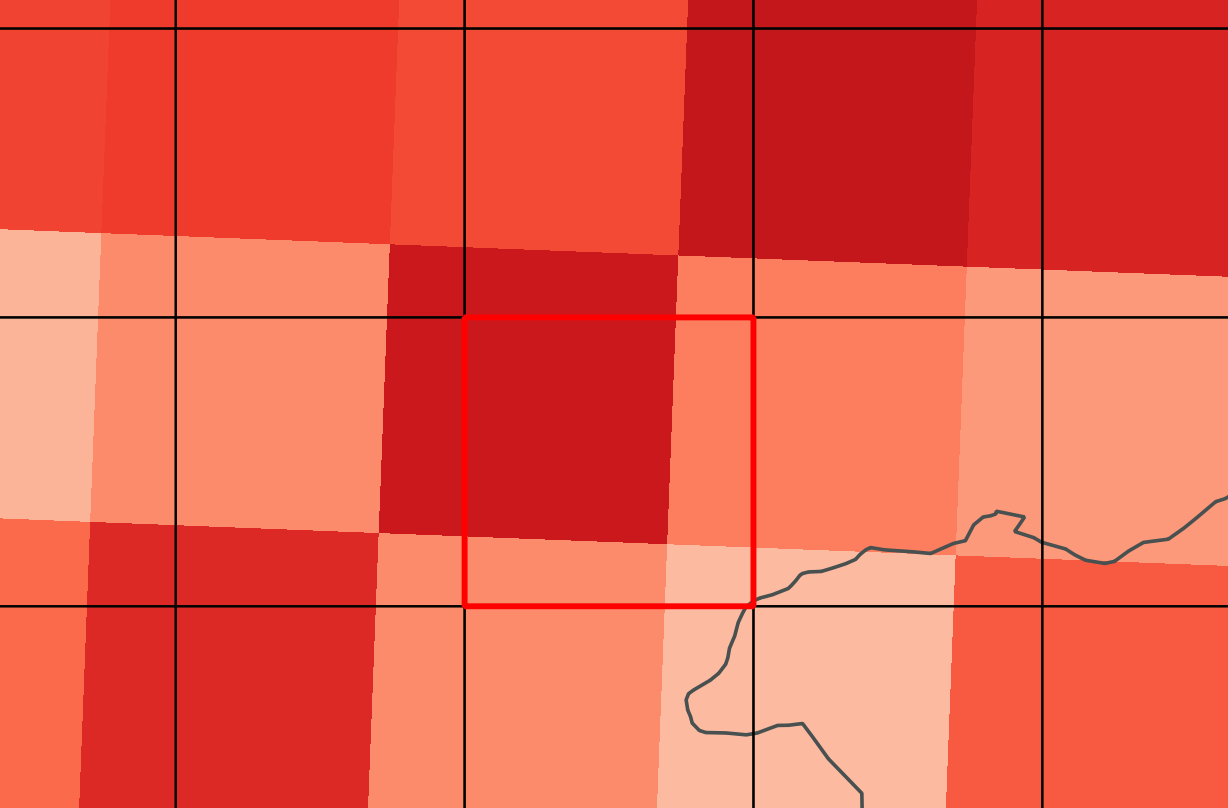 

This notebook shows how to do that.

In [1]:
import requests
import xarray as xr
import os
import pandas as pd

## Fetch data from Geosphere

In [2]:
def fetch_data_geosphere(endpoint, parameters, bbox, start_time, end_time, output_format='netcdf', dest=''):

    bbox_formatted = ', '.join([str(val) for val in bbox])
    params = {"parameters": parameters,
              "start": start_time,
              "end": end_time,
              "bbox": bbox_formatted,
              "output_format": output_format}

    response = requests.get(endpoint, params=params)

    if response.status_code == 200:  # OK status code means data is available
        if(output_format == 'netcdf'):
            # save file
            dir = f'{dest}{endpoint.split("/")[-1]}'
            output = f'{dir}/{"_".join(parameters)}_{start_time.split("T")[0]}_{end_time.split("T")[0]}.nc'
            if not os.path.exists(dir):
                try:
                    os.makedirs(dir)
                except OSError as e:
                    print(f"Error creating directory: {e}")
            with open(output, 'wb') as f:
                f.write(response.content)
            # open file with xarray
            data = xr.open_dataset(output, engine='netcdf4')
            return data
    else:
        print("Error:", response.status_code)
        return None

In [2]:
BBOX_EPSG4326 = 48.115278, 16.175833, 48.333056, 16.631944
# buffered bbox: BBOX_EPSG4326 + 0.001
BBOX_EPSG4326_buffer = [val + 0.001 for val in BBOX_EPSG4326]
SPARTACUS_ENDPOINT = "https://dataset.api.hub.geosphere.at/v1/grid/historical/spartacus-v2-1m-1km"
parameters = ["RR", "SA", "TM"]
start_time = '2024-01-01T00:00'
end_time = '2024-05-01T00:00'
dest = 'N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/'

#data = fetch_data_geosphere(SPARTACUS_ENDPOINT, parameters, BBOX_EPSG4326_buffer, start_time, end_time, output_format='netcdf', dest=dest)

## Regrid using gdal

In [15]:
def regrid_netcdf(source, dest, parameter, res=1000, resample_method='bilinear'):
    command = f'gdalwarp -s_srs EPSG:3416 -t_srs EPSG:31256 -tr {res} {res} -r {resample_method} -te -11200.0 331000.0 18800.0 354000.0 -te_srs EPSG:31256 -of netCDF "NETCDF:"""{source}""":{parameter}" {dest}'
    print(command)
    res = os.system(command)
    print(res)


In [18]:
# add again the time dimension and add metadata
def add_meta(input_path, date_list, parameter):
    ds = xr.open_dataset(input_path)
    band_list = [f"Band{i}" for i in range(1, len(date_list) + 1)]
    out = xr.concat([ds[band] for band in band_list], dim=pd.Index(date_list, name="time")).to_dataset(name=parameter)
    out.attrs['crs'] = 'EPSG:31256'
    out.attrs['history'] = ds.attrs['history'] + f'. Reprojected to EPSG:31256 with method bilinear with gdal.'
    out.attrs['author'] = 'space4environment sàrl for FAIRiCUBE'
    del ds
    out.to_netcdf(input_path)
    return out


In [ ]:
input = dest+'spartacus-v2-1d-1km/RR_SA_TN_TX_2020-01-01_2024-05-01.nc'
data_i = xr.open_dataset(input, engine = 'netcdf4')
data_i.time.values
parameters = ["RR", "SA", "TN", "TX"]
for parameter in parameters:
    output = dest+f'spartacus-v2-1d-1km/{parameter}_2020-01-01_2024-05-01_epsg31256_1km_regridded.nc'
    print(output)
    # regrid_netcdf(input, output, parameter)
    add_meta(output, data_i.time.values, parameter)

In [3]:
## resample to 100m grid
from rasterio.enums import Resampling
def upsample(input_path, upscale_factor):
    xds = xr.open_dataset(input_path, engine = 'netcdf4')
    new_width = xds.rio.width * upscale_factor
    new_height = xds.rio.height * upscale_factor
    xds.rio.write_crs('EPSG:31256', inplace=True)
    xds_upsampled = xds.rio.reproject(
        xds.rio.crs,
        shape=(new_height, new_width),
        resampling=Resampling.bilinear,
    )
    return xds_upsampled

In [ ]:
## resample to 100m grid
import glob
dest = 'N:\\C2205_FAIRiCUBE\\f02_data\\d050_data_WIEN\\climate\\'
files = glob.glob(dest+'spartacus-v2-1d-1km/*_1km_regridded.nc')
upscale_factor = 10
for file in files[1:]:
    print(file)
    output = file.replace('1km', '100m')
    xds_upsampled =  upsample(file, upscale_factor)
    xds_upsampled.attrs["history"] = xds_upsampled.attrs["history"] + '. Resampled to 100m'
    for var in list(xds_upsampled.data_vars):
        del xds_upsampled[var].attrs['grid_mapping']
    print(output)
    # xds_upsampled.to_netcdf('test.nc')
    xds_upsampled.to_netcdf(output)

## Convert to zarr file and upload to s3 bucket
TODO programmatic upload to s3 bucket

In [ ]:
# convert to zarr
files = glob.glob(dest+'spartacus-v2-1d-1km/*.nc')
for file in files:
    ds = xr.open_dataset(file)
    output = file.replace('nc', 'zarr')
    output = output.replace('spartacus-v2-1d-1km/', 'spartacus-v2-1d-1km/zarr_format/')
    print(output)
    ds.to_zarr(output)

## Compute time series trend and anomalies and other statistics
Perform computations in the original projection, then regrid

In [2]:
dest = 'N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/'
input = dest+'spartacus-v2-1d-1km/RR_SA_TN_TX_2020-01-01_2024-05-01.nc'
ds = xr.open_dataset(input)
ds

<xarray.Dataset>
Dimensions:                  (time: 1583, y: 26, x: 35)
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2024-05-01
  * x                        (x) int32 611500 612500 613500 ... 644500 645500
  * y                        (y) int32 472500 473500 474500 ... 496500 497500
Data variables:
    RR                       (time, y, x) float64 ...
    SA                       (time, y, x) float64 ...
    TN                       (time, y, x) float64 ...
    TX                       (time, y, x) float64 ...
Attributes: (12/14)
    Conventions:         CF-1.7
    author:              GeoSphere Austria (kontakt@geosphere.at)
    comment:             No additional comments
    crs:                 EPSG:3416
    freq:                1D
    grid_mapping:        lambert_conformal_conic
    ...                  ...
    name:                spartacus-daily v2.1
    references:          temperature - doi:10.1007/s00704-015-1411-4, precipi...
    source:              geostatistical interpolation of surface station obse...
    spatial_domain:      SPARTACUS
    spatial_resolution:  1000
    title:               SPARTACUS - Spatial Dataset for Climate in Austria

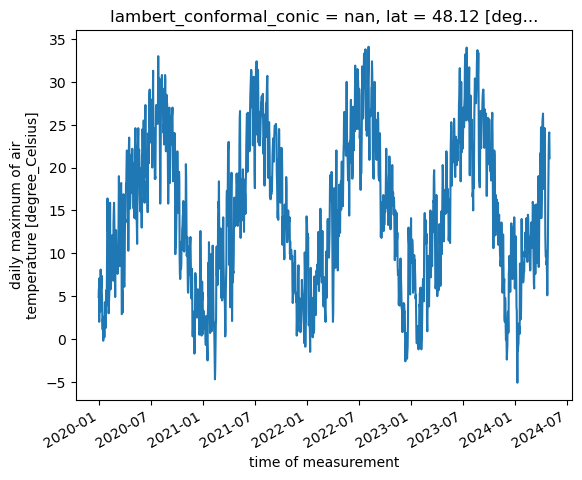

In [7]:
ds.TX.sel(x=611500, y=472500).plot()

### Yearly average

In [12]:
yearly_avg = ds.resample(time="1Y").mean()
yearly_avg.attrs["history"] = yearly_avg.attrs["history"] + '. Yearly means computed with xarray'
yearly_avg.attrs["source"] = 'original data metadata https://dataset.api.hub.geosphere.at/v1/grid/historical/spartacus-v2-1d-1km/metadata'
yearly_path_epsg3416 = dest+'spartacus-v2-1d-1km/RR_SA_TN_TX_yearly_avg_2020-2024_epsg3416.nc'
yearly_avg.to_netcdf(yearly_path_epsg3416,)

In [17]:
parameters = ["RR", "SA", "TN", "TX"]
for parameter in parameters:
    yearly_path_epsg31256 = dest+f'spartacus-v2-1d-1km/{parameter}_yearly_avg_2020-2024_epsg31256_1km_regridded.nc'
    regrid_netcdf(yearly_path_epsg3416, yearly_path_epsg31256, parameter)
    data_o = xr.open_dataset(yearly_path_epsg31256, engine = 'netcdf4')
    add_meta(yearly_path_epsg31256, yearly_avg.time.values, parameter)

gdalwarp -s_srs EPSG:3416 -t_srs EPSG:31256 -tr 1000 1000 -r bilinear -te -11200.0 331000.0 18800.0 354000.0 -te_srs EPSG:31256 -of netCDF "NETCDF:"""N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/spartacus-v2-1d-1km/RR_SA_TN_TX_yearly_avg_2020-2024_epsg3416.nc""":RR" N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/spartacus-v2-1d-1km/RR_yearly_avg_2020-2024_epsg31256_1km_regridded.nc
0
gdalwarp -s_srs EPSG:3416 -t_srs EPSG:31256 -tr 1000 1000 -r bilinear -te -11200.0 331000.0 18800.0 354000.0 -te_srs EPSG:31256 -of netCDF "NETCDF:"""N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/spartacus-v2-1d-1km/RR_SA_TN_TX_yearly_avg_2020-2024_epsg3416.nc""":SA" N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/spartacus-v2-1d-1km/SA_yearly_avg_2020-2024_epsg31256_1km_regridded.nc
0
gdalwarp -s_srs EPSG:3416 -t_srs EPSG:31256 -tr 1000 1000 -r bilinear -te -11200.0 331000.0 18800.0 354000.0 -te_srs EPSG:31256 -of netCDF "NETCDF:"""N:/C2205_FAIRiCUBE/f02_data/d050_data_WIEN/climate/spart

### Trends and anomalies

In [9]:
import pymannkendall as mk
def mk_trend_slope(vec, verbose=False):
    """Helper function to compute slope and p-value of Mann-Kendall test

    Args:
        vec (1D array): cell time series
        verbose (bool, optional): Whether to print values during computation. Defaults to False.

    Returns:
        tuple (float,float): Returns tuple of slope and p-value
    """
    trend=mk.original_test(vec)
    slope=trend.slope
    p = trend.p
    if verbose:
        print(slope,p)
    return (slope,p)

# ds_RR = ds.RR
# slope,pvalue = xr.apply_ufunc(mk_trend_slope,ds_RR,input_core_dims=[['time']], output_core_dims=[[],[]], vectorize=True)
# slope

In [10]:
ds_TX = ds.TX
slope,pvalue = xr.apply_ufunc(mk_trend_slope,ds_TX,input_core_dims=[['time']], output_core_dims=[[],[]], vectorize=True)
slope

<xarray.DataArray 'TX' (y: 26, x: 35)>
array([[0.00051348, 0.00053191, 0.00055788, 0.00051993, 0.00046598,
        0.00056899, 0.00057803, 0.00058594, 0.00059524, 0.00061728,
        0.00062668, 0.000625  , 0.00062112, 0.0006135 , 0.00059524,
        0.00059084, 0.00058708, 0.0005848 , 0.00057471, 0.00057937,
        0.00056818, 0.00056497, 0.00057307, 0.00058366, 0.00058893,
        0.00058997, 0.0006    , 0.00059746, 0.00060423, 0.00061397,
        0.00060976, 0.00060711, 0.0005698 , 0.00058252, 0.00059524],
       [0.00055866, 0.00055866, 0.00053548, 0.00055866, 0.0005618 ,
        0.00052219, 0.00057637, 0.00057471, 0.00058394, 0.00059524,
        0.00061082, 0.00061162, 0.00060852, 0.00060484, 0.00059583,
        0.00058997, 0.00058366, 0.00058055, 0.00057307, 0.00057637,
        0.00056926, 0.00056232, 0.00056604, 0.00057389, 0.00058824,
        0.00058824, 0.00058939, 0.0005988 , 0.00060189, 0.00060976,
        0.00059778, 0.00058824, 0.00056738, 0.0005814 , 0.00057915],
       [0.00056497, 0.00056417, 0.00056497, 0.00056604, 0.0005618 ,
        0.00056818, 0.00057307, 0.00056657, 0.00057471, 0.00058224,
        0.00059289, 0.0005988 , 0.0005988 , 0.00060241, 0.00060181,
        0.0005814 , 0.00057971, 0.00057471, 0.00057405, 0.00056444,
        0.00056338, 0.00055991, 0.00056022, 0.00057471, 0.00058224,
        0.00058651, 0.00058522, 0.00058651, 0.00059032, 0.0005988 ,
...
        0.00042481, 0.00044248, 0.00044248, 0.00047337, 0.00049554,
        0.00048403, 0.00046296, 0.00049261, 0.00045872, 0.00047506,
        0.00048544, 0.00050125, 0.00051813, 0.0005071 , 0.00050909,
        0.00050633, 0.00050505, 0.00051151, 0.00051546, 0.00050891,
        0.00050891, 0.00050548, 0.00050505, 0.00050934, 0.00050761,
        0.0005102 , 0.00050761, 0.00050633, 0.00050934, 0.00050891],
       [0.00042772, 0.00042553, 0.00042735, 0.00045524, 0.00043243,
        0.0004386 , 0.00043384, 0.00048193, 0.00047893, 0.00048077,
        0.00048544, 0.00046012, 0.00049261, 0.0004902 , 0.00048465,
        0.000489  , 0.00049296, 0.00051948, 0.00050916, 0.00050441,
        0.00050378, 0.00050505, 0.00050454, 0.00050293, 0.00051095,
        0.00051458, 0.0005102 , 0.00050697, 0.00050847, 0.0005102 ,
        0.00050891, 0.00051282, 0.00051591, 0.00051414, 0.00050556],
       [0.00042076, 0.00042735, 0.00043478, 0.00043783, 0.00044643,
        0.0004386 , 0.00043668, 0.00044803, 0.00047438, 0.00047348,
        0.00046083, 0.000489  , 0.0004931 , 0.000491  , 0.0004902 ,
        0.00049383, 0.00049383, 0.00051591, 0.0005102 , 0.00051086,
        0.00050505, 0.00050548, 0.00050761, 0.00050633, 0.0005036 ,
        0.00051546, 0.00051546, 0.00050847, 0.00051151, 0.00051282,
        0.00051348, 0.0005102 , 0.0005137 , 0.00051493, 0.0004603 ]])
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * x                        (x) int32 611500 612500 613500 ... 644500 645500
  * y                        (y) int32 472500 473500 474500 ... 496500 497500

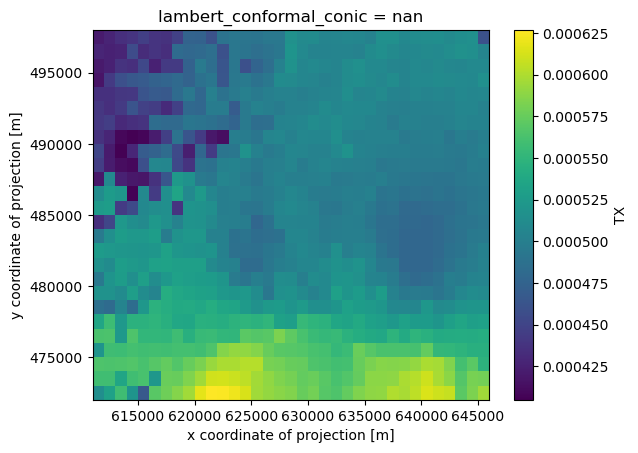

In [11]:
slope.plot()